In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime, timedelta

from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input

# Functions

In [3]:
def create_destination_features(dataframe):
  dataframe.reset_index(drop=True, inplace=True)
  differences_in_seconds = np.array([])
  distance = np.array([])
  number_of_rows = dataframe.shape[0]

  datetime = dataframe['BaseDateTime']
  last_row = datetime[number_of_rows-1]

  LAT = dataframe['LAT']
  last_LAT = LAT[number_of_rows-1]

  LON = dataframe['LON']
  last_LON = LON[number_of_rows-1]

  destination_LAT = [last_LAT for row in range(number_of_rows)]
  destination_LON = [last_LON for row in range(number_of_rows)]

  for row in range(number_of_rows):
    current_row = datetime[row]
    difference = (last_row-current_row).total_seconds()
    differences_in_seconds = np.append(differences_in_seconds, difference)

    dist = haversine(LAT[row], LON[row], last_LAT, last_LON)
    distance = np.append(distance, dist)

  dataframe.reset_index(drop=True, inplace=True)
  dataframe.drop(['BaseDateTime'], axis=1, inplace=True)

  dataframe['destination_LAT'] = pd.DataFrame(destination_LAT)
  dataframe['destination_LON'] = pd.DataFrame(destination_LON)
  dataframe['differences_in_seconds'] = pd.DataFrame(differences_in_seconds)
  dataframe['distance'] = pd.DataFrame(distance)
  return dataframe

In [4]:
def haversine(lat1, lon1, lat2, lon2):
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    radius = 6371  # Radius of the Earth in kilometers
    distance = radius * c

    return distance

In [5]:
def preprocess(dataframe):
  unique_cargo = dataframe['MMSI'].unique()
  preprocessed = pd.DataFrame()
  for each_cargo in unique_cargo:
    temp_dataframe = cargo[cargo['MMSI'] == each_cargo]
    temp_dataframe = create_destination_features(temp_dataframe)
    preprocessed = pd.concat([preprocessed, temp_dataframe], axis=0, ignore_index=True)

  #preprocessed.drop(['MMSI'], inplace=True)
  return preprocessed

# EDA

In [6]:
# Local runtime
# dataframe - pd.read_csv()
# dataframe.head(5)

In [7]:
# Colab
dataframe = pd.read_csv('/content/drive/MyDrive/Bangkit_Capstone/AIS_2022_03_31.csv')
dataframe.head(5)

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TransceiverClass
0,367702220,2022-03-31T00:00:01,29.78763,-95.08070,0.1,226.5,340.0,JOE B WARD,NaN,WDI4808,31.0,12.0,21.0,8.0,NaN,57.0,A
1,671226100,2022-03-31T00:00:01,25.77626,-80.20320,3.2,143.7,511.0,RELIANCE II,IMO9221322,5VHS7,79.0,0.0,52.0,12.0,2.5,70.0,A
2,367767250,2022-03-31T00:00:01,29.31623,-94.78829,4.5,228.1,511.0,GLEN K,NaN,WDJ3358,52.0,0.0,0.0,0.0,0.0,52.0,A
3,338327436,2022-03-31T00:00:03,47.29634,-122.42233,0.0,360.0,511.0,COOL KAT,IMO0000000,NaN,36.0,NaN,15.0,3.0,NaN,NaN,B
4,367452810,2022-03-31T00:00:06,29.32824,-94.77391,2.6,319.2,511.0,JOHN W JOHNSON,IMO9602344,WDF4516,60.0,0.0,80.0,19.0,3.0,60.0,A


In [8]:
dataframe.isnull().sum()

MMSI                      0
BaseDateTime              0
LAT                       0
LON                       0
SOG                       0
COG                       0
Heading                   0
VesselName            17201
IMO                 3368784
CallSign             833343
VesselType              817
Status              1628738
Length               438196
Width               1174077
Draft               4461321
Cargo               1624947
TransceiverClass          0
dtype: int64

In [9]:
dataframe['Status'].unique()

array([12.,  0., nan, 15.,  5.,  1.,  3.,  2., 11.,  7.,  8., 13.,  4.,
       10.,  9.,  6., 14.])

In [10]:
dataframe.drop(['VesselName', 'IMO', 'CallSign', 'Status', 'TransceiverClass'], axis=1, inplace=True)

In [11]:
# cargo vessel type code 70-79
cargo = dataframe[(dataframe['VesselType']>=70) & (dataframe['VesselType']<80)]
cargo.drop(['VesselType'], axis=1,inplace=True)
cargo.head(5)

<ipython-input-11-6599c22efa3a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cargo.drop(['VesselType'], axis=1,inplace=True)


,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,Length,Width,Draft,Cargo
1,671226100,2022-03-31T00:00:01,25.77626,-80.20320,3.2,143.7,511.0,52.0,12.0,2.5,70.0
8,538006349,2022-03-31T00:00:09,48.48308,-125.05758,11.9,89.1,90.0,NaN,NaN,NaN,70.0
25,354499000,2022-03-31T00:00:04,29.18968,-94.63571,0.2,193.5,107.0,336.0,45.0,15.0,71.0
38,356436000,2022-03-31T00:00:00,26.06004,-80.13008,0.0,46.4,261.0,225.0,32.0,13.2,70.0
136,564411000,2022-03-31T00:00:04,29.95339,-90.30581,0.1,249.3,216.0,189.0,32.0,12.6,70.0


In [12]:
cargo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 607971 entries, 1 to 7166975
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   MMSI          607971 non-null  int64  
 1   BaseDateTime  607971 non-null  object 
 2   LAT           607971 non-null  float64
 3   LON           607971 non-null  float64
 4   SOG           607971 non-null  float64
 5   COG           607971 non-null  float64
 6   Heading       607971 non-null  float64
 7   Length        589662 non-null  float64
 8   Width         559574 non-null  float64
 9   Draft         547282 non-null  float64
 10  Cargo         605769 non-null  float64
dtypes: float64(9), int64(1), object(1)
memory usage: 55.7+ MB


In [13]:
cargo['BaseDateTime'] = pd.to_datetime(cargo['BaseDateTime'], errors='coerce')
cargo = cargo.sort_values(by=['MMSI', 'BaseDateTime'], ignore_index=True)
cargo.head(10)

<ipython-input-13-3431515a4e37>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cargo['BaseDateTime'] = pd.to_datetime(cargo['BaseDateTime'], errors='coerce')


,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,Length,Width,Draft,Cargo
0,209087000,2022-03-31 01:43:54,38.00907,-74.53090,10.7,175.8,176.0,271.0,43.0,10.7,70.0
1,209087000,2022-03-31 01:45:03,38.00560,-74.53053,10.7,175.5,176.0,271.0,43.0,10.7,70.0
2,209087000,2022-03-31 01:46:13,38.00204,-74.53017,10.7,175.4,177.0,271.0,43.0,10.7,70.0
3,209087000,2022-03-31 01:47:23,37.99861,-74.52980,10.7,175.0,177.0,271.0,43.0,10.7,70.0
4,209087000,2022-03-31 01:48:33,37.99509,-74.52945,10.7,175.4,177.0,271.0,43.0,10.7,70.0
5,209087000,2022-03-31 01:49:43,37.99153,-74.52913,10.7,176.1,177.0,271.0,43.0,10.7,70.0
6,209087000,2022-03-31 01:50:54,37.98798,-74.52880,10.7,176.0,177.0,271.0,43.0,10.7,70.0
7,209087000,2022-03-31 01:52:03,37.98453,-74.52852,10.7,176.1,177.0,271.0,43.0,10.7,70.0
8,209087000,2022-03-31 01:53:13,37.98108,-74.52821,10.7,175.7,177.0,271.0,43.0,10.7,70.0
9,209087000,2022-03-31 01:54:23,37.97753,-74.52787,10.7,175.8,177.0,271.0,43.0,10.7,70.0


In [14]:
cargo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607971 entries, 0 to 607970
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   MMSI          607971 non-null  int64         
 1   BaseDateTime  607971 non-null  datetime64[ns]
 2   LAT           607971 non-null  float64       
 3   LON           607971 non-null  float64       
 4   SOG           607971 non-null  float64       
 5   COG           607971 non-null  float64       
 6   Heading       607971 non-null  float64       
 7   Length        589662 non-null  float64       
 8   Width         559574 non-null  float64       
 9   Draft         547282 non-null  float64       
 10  Cargo         605769 non-null  float64       
dtypes: datetime64[ns](1), float64(9), int64(1)
memory usage: 51.0 MB


In [15]:
cargo.shape[0]

607971

In [16]:
cargo.isnull().sum()

MMSI                0
BaseDateTime        0
LAT                 0
LON                 0
SOG                 0
COG                 0
Heading             0
Length          18309
Width           48397
Draft           60689
Cargo            2202
dtype: int64

In [17]:
cargo.dropna(inplace=True)
unique_cargo = cargo['MMSI'].unique()
len(unique_cargo)

1206

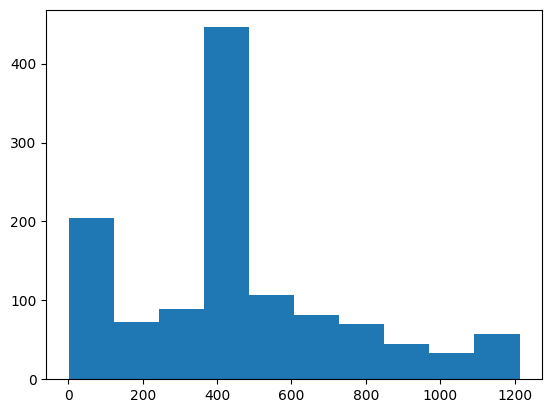

In [18]:
# checking number of rows for each cargo
number_of_rows = np.array([])
for each_cargo in unique_cargo:
  id_cargo = cargo[cargo['MMSI'] == each_cargo]
  number_of_rows = np.append(number_of_rows, id_cargo.shape[0])

plt.hist(number_of_rows)
plt.show()

In [19]:
cargo_data = pd.DataFrame()
cargo_data['MMSI'] = unique_cargo
cargo_data['number_of_rows'] = number_of_rows
cargo_data = cargo_data.sort_values(by=['number_of_rows'], ascending=False)
cargo_data

,MMSI,number_of_rows
118,244340000,1213.0
539,368106220,1201.0
1075,636017540,1199.0
318,316013966,1197.0
549,368473000,1191.0
...,...,...
823,538005710,1.0
1177,636092681,1.0
952,563131700,1.0
899,538009390,1.0


In [20]:
lacking_dataframe = cargo_data[cargo_data['number_of_rows'] < 100]
lacking_data = np.array(lacking_dataframe['MMSI'])
lacking_dataframe

,MMSI,number_of_rows
4,209289000,98.0
598,372089000,97.0
344,338217000,95.0
993,566548000,90.0
970,565032000,85.0
...,...,...
823,538005710,1.0
1177,636092681,1.0
952,563131700,1.0
899,538009390,1.0


In [21]:
# delete lacking data cargo
cargo = cargo[~cargo['MMSI'].isin(lacking_data)]
cargo

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,Length,Width,Draft,Cargo
0,209087000,2022-03-31 01:43:54,38.00907,-74.53090,10.7,175.8,176.0,271.0,43.0,10.7,70.0
1,209087000,2022-03-31 01:45:03,38.00560,-74.53053,10.7,175.5,176.0,271.0,43.0,10.7,70.0
2,209087000,2022-03-31 01:46:13,38.00204,-74.53017,10.7,175.4,177.0,271.0,43.0,10.7,70.0
3,209087000,2022-03-31 01:47:23,37.99861,-74.52980,10.7,175.0,177.0,271.0,43.0,10.7,70.0
4,209087000,2022-03-31 01:48:33,37.99509,-74.52945,10.7,175.4,177.0,271.0,43.0,10.7,70.0
...,...,...,...,...,...,...,...,...,...,...,...
607966,720181000,2022-03-31 18:49:17,25.79929,-80.25011,0.0,235.7,511.0,33.0,10.0,2.5,77.0
607967,720181000,2022-03-31 18:50:27,25.79929,-80.25011,0.0,216.6,511.0,33.0,10.0,2.5,77.0
607968,720181000,2022-03-31 18:51:38,25.79925,-80.25008,0.0,218.4,511.0,33.0,10.0,2.5,77.0
607969,720181000,2022-03-31 18:52:48,25.79926,-80.25012,0.0,266.4,511.0,33.0,10.0,2.5,77.0


# Feature Engineering

In [22]:
train = preprocess(cargo)
train.dropna(inplace=True)
train.drop(['MMSI'], axis=1, inplace=True)

Streaming output truncated to the last 5000 lines.
<ipython-input-3-75baa2034954>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['differences_in_seconds'] = pd.DataFrame(differences_in_seconds)
<ipython-input-3-75baa2034954>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['distance'] = pd.DataFrame(distance)
<ipython-input-3-75baa2034954>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pand

In [23]:
train

,LAT,LON,SOG,COG,Heading,Length,Width,Draft,Cargo,destination_LAT,destination_LON,differences_in_seconds,distance
0,38.00907,-74.53090,10.7,175.8,176.0,271.0,43.0,10.7,70.0,36.75856,-75.59033,80106.0,167.618075
1,38.00560,-74.53053,10.7,175.5,176.0,271.0,43.0,10.7,70.0,36.75856,-75.59033,80037.0,167.317647
2,38.00204,-74.53017,10.7,175.4,177.0,271.0,43.0,10.7,70.0,36.75856,-75.59033,79967.0,167.008830
3,37.99861,-74.52980,10.7,175.0,177.0,271.0,43.0,10.7,70.0,36.75856,-75.59033,79897.0,166.712794
4,37.99509,-74.52945,10.7,175.4,177.0,271.0,43.0,10.7,70.0,36.75856,-75.59033,79827.0,166.407882
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540617,25.79929,-80.25011,0.0,235.7,511.0,33.0,10.0,2.5,77.0,25.79923,-80.25016,281.0,0.008341
540618,25.79929,-80.25011,0.0,216.6,511.0,33.0,10.0,2.5,77.0,25.79923,-80.25016,211.0,0.008341
540619,25.79925,-80.25008,0.0,218.4,511.0,33.0,10.0,2.5,77.0,25.79923,-80.25016,140.0,0.008312
540620,25.79926,-80.25012,0.0,266.4,511.0,33.0,10.0,2.5,77.0,25.79923,-80.25016,70.0,0.005212


# Model

Split the data into training and test sets

In [ ]:
train_dataset = train.sample(frac=0.8, random_state=42)
test_dataset = train.drop(train_dataset.index)

Inspect the data

In [ ]:
# sns.pairplot(train_dataset[['differences_in_seconds', 'LON', 'LAT', 'SOG', 'COG', 'destination_LAT', 'destination_LON']], diag_kind='kde')

In [ ]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
LAT,432498.0,34.869210,7.716029,12.87283,29.546030,33.738880,40.47542,49.602150
LON,432498.0,-93.083005,20.901851,-158.36258,-118.074890,-88.927660,-78.48736,144.636920
SOG,432498.0,4.955914,6.841795,0.00000,0.000000,0.300000,10.50000,102.300000
COG,432498.0,183.646821,104.550994,0.00000,97.700000,182.600000,271.50000,360.000000
Heading,432498.0,197.338670,117.595887,0.00000,102.000000,185.000000,282.00000,511.000000
Length,432498.0,213.490744,76.213026,0.00000,179.000000,199.000000,265.00000,396.000000
Width,432498.0,31.115767,9.364777,0.00000,26.000000,32.000000,33.00000,54.000000
Draft,432498.0,10.226901,3.292035,0.00000,8.200000,10.200000,12.70000,18.500000
Cargo,432498.0,70.445299,8.627236,0.00000,70.000000,70.000000,71.00000,99.000000
destination_LAT,432498.0,34.804241,7.747004,12.87283,29.542410,33.734490,40.45484,49.311790


Split Features From Labels

In [ ]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('differences_in_seconds')
test_labels = test_features.pop('differences_in_seconds')

Normalization

In [ ]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
LAT,34.869210,7.716029
LON,-93.083005,20.901851
SOG,4.955914,6.841795
COG,183.646821,104.550994
Heading,197.338670,117.595887
Length,213.490744,76.213026
Width,31.115767,9.364777
Draft,10.226901,3.292035
Cargo,70.445299,8.627236
destination_LAT,34.804241,7.747004


In [ ]:
train_features

,LAT,LON,SOG,COG,Heading,Length,Width,Draft,Cargo,destination_LAT,destination_LON,distance
76846,40.49859,-73.72797,0.2,318.6,220.0,300.0,48.0,13.7,71.0,40.50068,-73.72901,0.248478
463355,25.78948,-80.06643,7.0,122.0,135.0,334.0,42.0,14.5,70.0,25.76625,-80.15690,9.419800
237621,29.74758,-95.11141,0.0,238.0,238.0,149.0,22.0,9.1,72.0,29.60420,-94.95036,22.277113
122806,27.93520,-82.44532,0.1,177.9,20.0,178.0,29.0,6.5,70.0,27.93519,-82.44534,0.002258
136375,48.34088,-89.15462,0.0,301.0,72.0,212.0,21.0,8.0,70.0,48.71763,-87.60573,121.503784
...,...,...,...,...,...,...,...,...,...,...,...,...
188292,49.30638,-123.19001,0.0,271.3,92.0,292.0,44.0,18.0,70.0,48.22372,-123.87639,130.473442
276136,33.37545,-77.57037,9.8,248.5,240.0,242.0,32.0,11.7,71.0,32.11431,-79.47116,226.415186
156527,21.37100,-157.97286,0.0,48.7,120.0,94.0,18.0,6.0,70.0,21.37109,-157.97282,0.010831
466855,26.60026,-79.16097,1.6,348.8,65.0,294.0,32.0,13.5,70.0,26.53044,-78.76335,40.300357


**Regression with a deep neural network (DNN)**

In [ ]:
model = keras.Sequential([
    layers.InputLayer(input_shape=(12)),
    layers.Dense(units=1024, activation='gelu'),
    layers.BatchNormalization(),
    layers.Dense(units=512, activation='gelu'),
    layers.BatchNormalization(),
    layers.Dense(units=512, activation='gelu'),
    layers.BatchNormalization(),
    layers.Dense(units=256, activation='gelu'),
    layers.BatchNormalization(),
    layers.Dense(units=256, activation='gelu'),
    layers.BatchNormalization(),
    layers.Dense(units=1, activation='relu')
])

model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.losses.MeanAbsoluteError()])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              13312     
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 batch_normalization_2 (Batc  (None, 512)              2

In [ ]:
%%time
history = model.fit(
    train_features,
    train_labels,
    batch_size = 128,
    validation_split=0.2,
    verbose=1, epochs=150)

2704/2704 [==============================] - 70s 26ms/step - loss: 1582226432.0000 - root_mean_squared_error: 39777.2109 - mean_absolute_error: 33630.7266 - val_loss: 1538508160.0000 - val_root_mean_squared_error: 39223.8203 - val_mean_absolute_error: 33121.1914
Epoch 16/150
2704/2704 [==============================] - 69s 25ms/step - loss: 1522796672.0000 - root_mean_squared_error: 39023.0273 - mean_absolute_error: 32961.6445 - val_loss: 1475018496.0000 - val_root_mean_squared_error: 38405.9688 - val_mean_absolute_error: 32371.3965
Epoch 17/150
2704/2704 [==============================] - 68s 25ms/step - loss: 1460920064.0000 - root_mean_squared_error: 38221.9844 - mean_absolute_error: 32254.0156 - val_loss: 1440373376.0000 - val_root_mean_squared_error: 37952.2500 - val_mean_absolute_error: 32029.9023
Epoch 18/150
2704/2704 [==============================] - 67s 25ms/step - loss: 1397336576.0000 - root_mean_squared_error: 37380.9648 - mean_absolute_error: 31515.2656 - val_loss: 13492

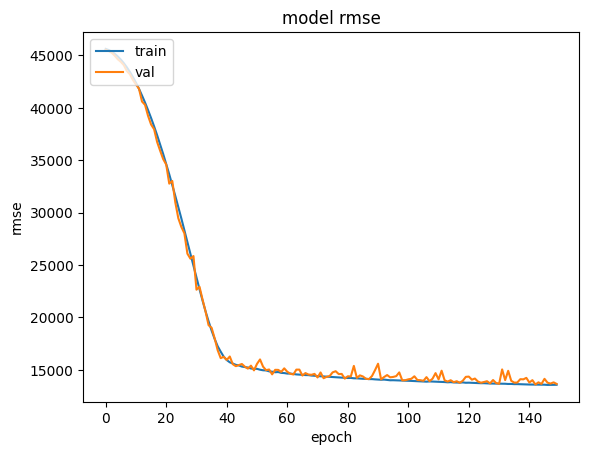

In [ ]:
# summarize history for rmse
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

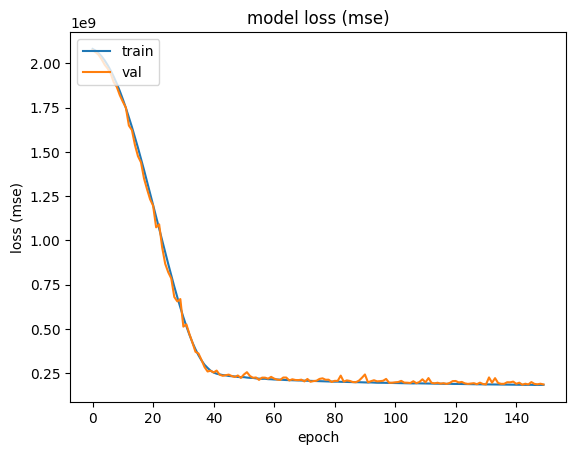

In [ ]:
# summarize history for mse
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss (mse)')
plt.ylabel('loss (mse)')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

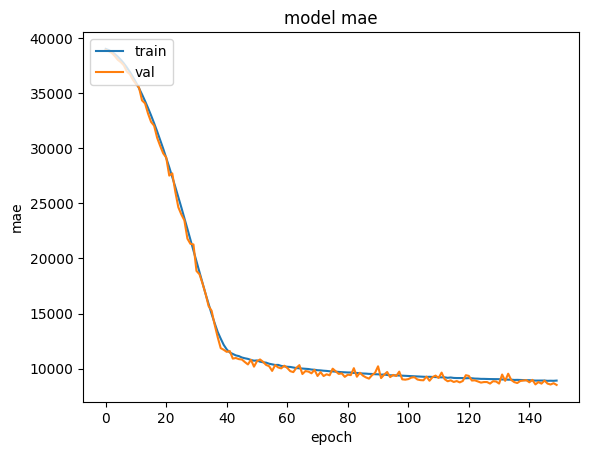

In [ ]:
# summarize history for mae
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Export model

In [ ]:
# save as .h5
model.save('/content/drive/MyDrive/Bangkit_Capstone/model.h5')

# Load model

In [26]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Bangkit_Capstone/model.h5', custom_objects={'MeanAbsoluteError': tf.keras.losses.MeanAbsoluteError})

# Predict

In [30]:
test_df = pd.read_csv('/content/drive/MyDrive/Bangkit_Capstone/preprocessed.csv')
row_data = 0
MMSI = test_df.iloc[row_data, 0]
reference_datetime = test_df.iloc[row_data, 1]
input_feature = test_df.iloc[row_data, 2:]

# input preparation
input_array = input_feature.to_numpy(dtype='float32')
array_to_tensor = tf.convert_to_tensor(input_array)
input_tensor = tf.expand_dims(array_to_tensor, axis=0)
travel_time = loaded_model.predict(input_tensor)

float_seconds = travel_time[0][0]
float_seconds = float_seconds.item() # np.float -> float
duration_delta = timedelta(seconds=float_seconds) # float -> datetime.timedelta

# convert string to datetime
datetime_string_format = '%Y-%m-%d %H:%M:%S'
base_datetime = datetime.strptime(reference_datetime, datetime_string_format)
arrival_datetime = base_datetime + duration_delta

1/1 [==============================] - 0s 18ms/step


In [48]:
duration_delta

datetime.timedelta(seconds=30210, microseconds=511719)

In [42]:
test_df

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,Length,Width,Draft,Cargo,destination_LAT,destination_LON,distance
0,209087000,2022-03-30 00:00:05,39.84931,-75.30936,12.7,91.6,93.0,271.0,43.0,13.6,70.0,38.43993,-74.71892,164.779071
1,209087000,2022-03-30 00:01:07,39.84923,-75.30476,12.0,90.7,95.0,271.0,43.0,13.6,70.0,38.43993,-74.71892,164.648483
2,209087000,2022-03-30 00:02:25,39.84896,-75.29940,11.0,93.8,96.0,271.0,43.0,13.6,70.0,38.43993,-74.71892,164.478690
3,209087000,2022-03-30 00:03:35,39.84859,-75.29498,10.2,96.1,97.0,271.0,43.0,13.6,70.0,38.43993,-74.71892,164.323921
4,209087000,2022-03-30 00:04:46,39.84828,-75.29081,9.5,95.9,97.0,271.0,43.0,13.6,70.0,38.43993,-74.71892,164.182731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612922,720181000,2022-03-30 18:26:14,25.72769,-79.41160,9.1,83.4,511.0,33.0,10.0,2.5,77.0,25.72536,-79.36880,4.295219
612923,720181000,2022-03-30 18:27:35,25.72778,-79.40789,8.9,91.6,511.0,33.0,10.0,2.5,77.0,25.72536,-79.36880,3.924991
612924,720181000,2022-03-30 18:30:45,25.72761,-79.39920,9.0,88.7,511.0,33.0,10.0,2.5,77.0,25.72536,-79.36880,3.055516
612925,720181000,2022-03-30 18:38:16,25.72554,-79.37907,9.1,89.7,511.0,33.0,10.0,2.5,77.0,25.72536,-79.36880,1.028979


In [34]:
MMSI

209087000

In [31]:
arrival_datetime

datetime.datetime(2022, 3, 30, 8, 23, 35, 511719)

In [43]:
truth_df = pd.read_csv('/content/drive/MyDrive/Bangkit_Capstone/AIS_2022_03_30.csv')

In [44]:
truth_ship = truth_df[truth_df['MMSI'] == MMSI].sort_values(by=['BaseDateTime'], ascending=False)
truth_ship.reset_index(drop=True, inplace=True)
truth_ship

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TransceiverClass
0,209087000,2022-03-30T23:10:42,38.43993,-74.71892,11.0,144.7,147.0,CAPE PIONEER,IMO9719874,5BUE4,70.0,0.0,271.0,43.0,10.7,70.0,A
1,209087000,2022-03-30T23:09:33,38.44282,-74.72155,10.9,144.7,146.0,CAPE PIONEER,IMO9719874,5BUE4,70.0,0.0,271.0,43.0,10.7,70.0,A
2,209087000,2022-03-30T23:08:24,38.44567,-74.72413,10.9,144.4,146.0,CAPE PIONEER,IMO9719874,5BUE4,70.0,0.0,271.0,43.0,10.7,70.0,A
3,209087000,2022-03-30T23:07:22,38.44821,-74.72642,10.9,145.0,147.0,CAPE PIONEER,IMO9719874,5BUE4,70.0,0.0,271.0,43.0,10.7,70.0,A
4,209087000,2022-03-30T23:06:12,38.45112,-74.72903,10.9,144.9,147.0,CAPE PIONEER,IMO9719874,5BUE4,70.0,0.0,271.0,43.0,10.7,70.0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,209087000,2022-03-30T00:04:46,39.84828,-75.29081,9.5,95.9,97.0,CAPE PIONEER,IMO9719874,5BUE4,70.0,0.0,271.0,43.0,13.6,70.0,A
820,209087000,2022-03-30T00:03:35,39.84859,-75.29498,10.2,96.1,97.0,CAPE PIONEER,IMO9719874,5BUE4,70.0,0.0,271.0,43.0,13.6,70.0,A
821,209087000,2022-03-30T00:02:25,39.84896,-75.29940,11.0,93.8,96.0,CAPE PIONEER,IMO9719874,5BUE4,70.0,0.0,271.0,43.0,13.6,70.0,A
822,209087000,2022-03-30T00:01:07,39.84923,-75.30476,12.0,90.7,95.0,CAPE PIONEER,IMO9719874,5BUE4,70.0,0.0,271.0,43.0,13.6,70.0,A


In [47]:
datetime_truth_format = '%Y-%m-%dT%H:%M:%S'
truth = truth_ship['BaseDateTime'][0]
truth_time = datetime.strptime(truth, datetime_truth_format)
truth_time

datetime.datetime(2022, 3, 30, 23, 10, 42)